# Image augmentation

Image augmentation technology expands the scale of training datasets by making a series of random changes to the training images to produce similar, but different, training examples. Another way to explain image augmentation is that <font color=red>randomly changing training examples can reduce a model’s dependence on certain properties, thereby improving its capability for generalization</font>. For example, we can crop the images in different ways, so that the objects of interest appear in different positions, reducing the model’s dependence on the position where objects appear. We can also adjust the brightness, color, and other factors to reduce model’s sensitivity to color. It can be said that image augmentation technology contributed greatly to the success of AlexNet. In this section, we will discuss this technology, which is widely used in computer vision.

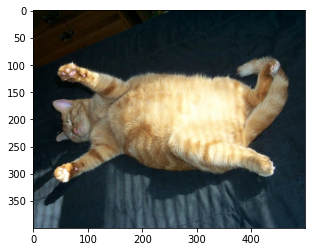

In [11]:
import sys
sys.path.insert(0, '..')

import d2l
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader

img = cv2.imread('../img/cat1.jpg', cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [10]:
from PIL import Image
img = Image.open('../img/cat1.jpg')

Most image augmentation methods have a certain degree of randomness. To make it easier for us to observe the effect of image augmentation, we next define the auxiliary function `apply`. This function runs the image augmentation method aug multiple times on the input image img and shows all results.

In [11]:
import numpy

def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale=scale)

def show_images(imgs, num_rows, num_cols, titles=None, scale=2.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if isinstance(img, torch.Tensor):
            img = torch.squeeze(img).numpy()            
            img = numpy.transpose(img, (1, 2, 0))
            ax.imshow(img)
        else:
            ax.imshow(numpy.array(img))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

## Flipping and Cropping
Flipping the image left and right usually does not change the category of the object. This is one of the earliest and most widely used methods of image augmentation.

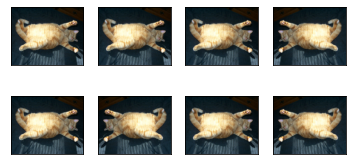

In [23]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

Flipping up and down is not as commonly used as flipping left and right. However, at least for this example image, flipping up and down does not hinder recognition. Next, we create a RandomFlipTopBottom instance for a 50% chance of flipping the image up and down.

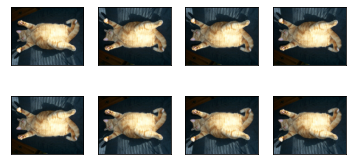

In [24]:
apply(img, torchvision.transforms.RandomVerticalFlip())

In the example image we used, the cat is in the middle of the image, but this may not be the case for all images. In Section 6.5, we explained that <font color=red>the pooling layer can reduce the sensitivity of the convolutional layer to the target location.</font> In addition, we can make objects appear at different positions in the image in different proportions by randomly cropping the image. This can also reduce the sensitivity of the model to the target position.

In the following code, we randomly crop a region with an area of 10% to 100% of the original area, and the ratio of width to height of the region is randomly selected from between 0.5 and 2. Then, the width and height of the region are both scaled to 200 pixels. Unless otherwise stated, the random number between  𝑎  and  𝑏  in this section refers to a continuous value obtained by uniform sampling in the interval  [𝑎,𝑏] .

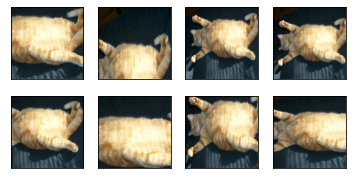

In [25]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

## Changing the Color
Another augmentation method is changing colors. We can change four aspects of the image color: <font color=red>brightness, contrast, saturation, and hue</font>. In the example below, we randomly change the brightness of the image to a value between 50% ( 1−0.5 ) and 150% ( 1+0.5 ) of the original image.

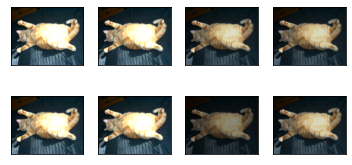

In [26]:
# torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

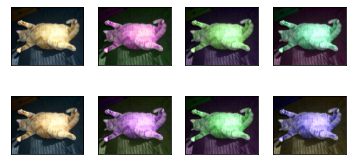

In [27]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

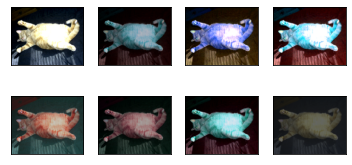

In [13]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

## Overlying Multiple Image Augmentation Methods
In practice, we will overlay multiple image augmentation methods. We can overlay the different image augmentation methods defined above and apply them to each image by using a Compose instance.

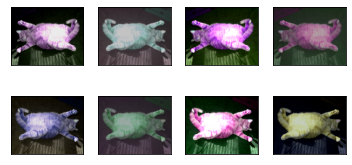

In [14]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug])
apply(img, augs)

## Using an Image Augmentation Training Model
Next, we will look at how to apply image augmentation in actual training. Here, we use the CIFAR-10 dataset, instead of the Fashion-MNIST dataset we have been using. This is because the position and size of the objects in the Fashion-MNIST dataset have been normalized, and the differences in color and size of the objects in CIFAR-10 dataset are more significant. The first 32 training images in the CIFAR-10 dataset are shown below.

In [15]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])
cifar_train = torchvision.datasets.CIFAR10(root='../data', train=True, download=False, transform=transform)
cifar_test = torchvision.datasets.CIFAR10(root='../data', train=False, download=False, transform=transform)

torch.Size([32, 3, 32, 32])


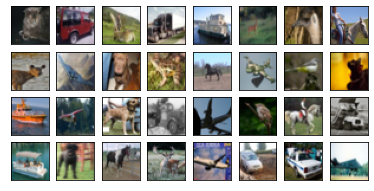

In [16]:
from torch.utils.data import DataLoader
train_iter = DataLoader(cifar_train, batch_size=32, shuffle=True)
X, y = iter(train_iter).next()
_ = show_images(X, 4, 8, scale=0.8)
print(X.shape)

<font color=red>In order to obtain definitive results during prediction, we usually only apply image augmentation to the training example</font>, and do not use image augmentation with random operations during prediction. Here, we only use the simplest random left-right flipping method. In addition, we use a ToTensor instance to convert minibatch images into the format required by Pytorch, i.e., 32-bit floating point numbers with the shape of (batch size, number of channels, height, width) and value range between 0 and 1.

In [4]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

In [12]:
def load_data(batch_size):
    folder_path = "../data"
    cifar_train = torchvision.datasets.CIFAR10(root=folder_path, train=True, download=False, transform=train_augs)
    cifar_test = torchvision.datasets.CIFAR10(root=folder_path, train=False, download=False, transform=test_augs)

    return DataLoader(cifar_train, batch_size=batch_size, num_workers=4, shuffle=True), \
           DataLoader(cifar_test, batch_size=batch_size, num_workers=4, shuffle=False)


### ResNet-18 model on CIFAR-10 dataset
Data parallelism: https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html

In [8]:
class Residual(nn.Module):
    def __init__(self, input_channels, output_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)

        return self.relu(Y + X)


class Flatten(nn.Module):
    def forward(self, X):
        return X.view(X.size(0), -1)


def reset_block(input_channels, output_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        # if input_channels does not equal output_channels, first_block is False
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, output_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(output_channels, output_channels))
    return blk


def resnet(num_classes):
    module_list = [nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                                 nn.BatchNorm2d(64),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                   nn.Sequential(*reset_block(64, 64, 2, first_block=True)),
                   nn.Sequential(*reset_block(64, 128, 2)),
                   nn.Sequential(*reset_block(128, 256, 2)),
                   nn.Sequential(*reset_block(256, 512, 2)),
                   nn.AdaptiveAvgPool2d((1, 1)),
                   Flatten(),
                   nn.Linear(512, num_classes)]
    return nn.Sequential(*module_list)

In [17]:
def train_ch13(net, train_iter, test_iter, loss, optimizer, num_epochs, device):
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0, 1],
                           legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(device), labels.to(device)
            l, acc = train_batch(net, features, labels, loss, optimizer)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            
            if (i + 1) % (num_batches // 5) == 0:
                animator.add(epoch + i / num_batches, 
                            (metric[0] / metric[2], metric[1] / metric[2], None))
        
        test_acc = d2l.evaluate_accuracy_gpus(net, test_iter, split_f)
        animator.add(epoch + 1, (None, None, test_acc))
    
        print(f"loss {metric[0]/metric[2]: .3f}, train acc {metric[0]/metric[2]: .3f},"
             f"test acc {test_acc: .3f}")
        print(f"{metric[2] * num_epochs / timer.sum(): .1f} examples on {ctx_list}")

In [20]:
def train_batch(net, features, labels, loss, optimizer):
    optimizer.zero_grad()
    y_hat = net(features)
    l = loss(y_hat, labels)
    l.backward()
    optimizer.step()
    
    return l.item(), (y_hat.argmax(dim=1) == labels).sum().item()

Traceback (most recent call last):
  File "/opt/anaconda3/envs/dive_into_deep_learning/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/envs/dive_into_deep_learning/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/envs/dive_into_deep_learning/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/envs/dive_into_deep_learning/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

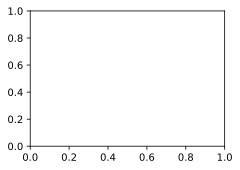

In [22]:
batch_size = 16
lr = 1.0e-3
num_epoch = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_iter, test_iter = load_data(batch_size)
net = resnet(num_classes=10)
net.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
if torch.cuda.device_count():
    net = nn.DataParallel(net)

train_ch13(net, train_iter, test_iter, loss, optimizer, num_epoch, device)